<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

- Lets install the necessary libs
  - transformers
  - pl
  - torchmetrics

In [1]:
!pip install transformers
!pip install datasets
!pip install pytorch_lightning
!pip install torchmetrics
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 11.8 MB/s 
     |████████████████████████████████| 596 kB 51.7 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 45.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 27.5 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 140 kB 74.9 MB/s 
     |████████████████████████████████| 127 kB 64.7 MB/s 
     |████████████████████████████████| 271 kB 74.2 MB/s 
     |█████████████

# Import libraries

In [3]:
from datasets import load_dataset
from transformers import Wav2Vec2FeatureExtractor, Data2VecAudioForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import scikitplot as skplt
from torchmetrics import Accuracy, MatthewsCorrCoef

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import Audio

In [4]:
dataset = load_dataset('speech_commands', 'v0.01')

Generating train split:   0%|          | 0/51093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

Dataset speech_commands downloaded and prepared to /root/.cache/huggingface/datasets/speech_commands/v0.01/0.1.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 51093
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 6799
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 3081
    })
})

In [6]:
audio_data = dataset['train'][0]['audio']
wav.write('out.wav', audio_data['sampling_rate'], audio_data['array'])

Audio('out.wav')

# Vis data

In [7]:
# convert data to dataframe
train_df = dataset['train'].to_pandas()

In [8]:
train_df.head()

,file,audio,label,is_unknown,speaker_id,utterance_id
0,bed/4a294341_nohash_0.wav,{'bytes': b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00...,20,True,4a294341,0
1,bed/43f57297_nohash_0.wav,{'bytes': b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00...,20,True,43f57297,0
2,bed/f9af823e_nohash_1.wav,{'bytes': b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00...,20,True,f9af823e,1
3,bed/9ff2d2f4_nohash_0.wav,{'bytes': b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00...,20,True,9ff2d2f4,0
4,bed/651d108f_nohash_0.wav,{'bytes': b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00...,20,True,651d108f,0


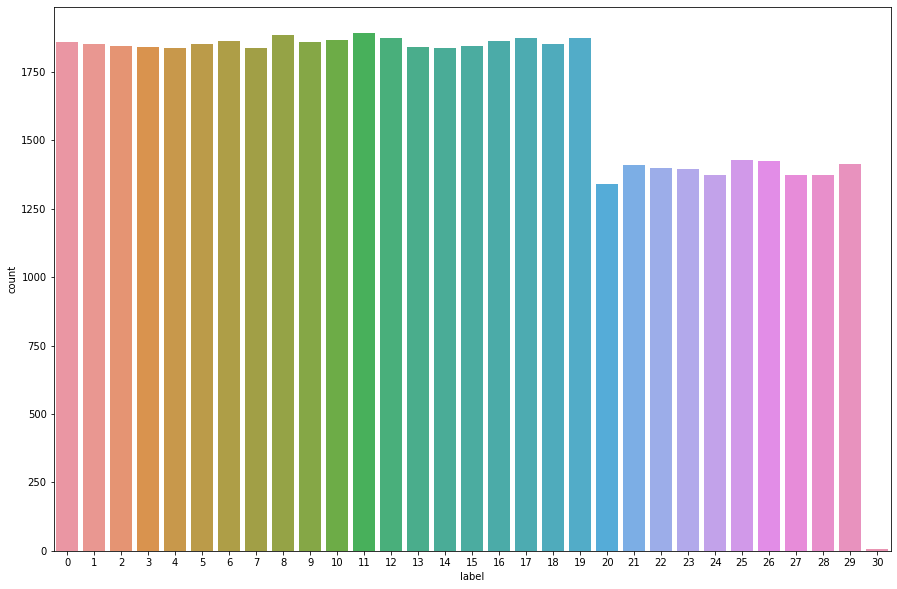

In [9]:
plt.figure(figsize=(15, 10))
sns.countplot(data=train_df, x='label')

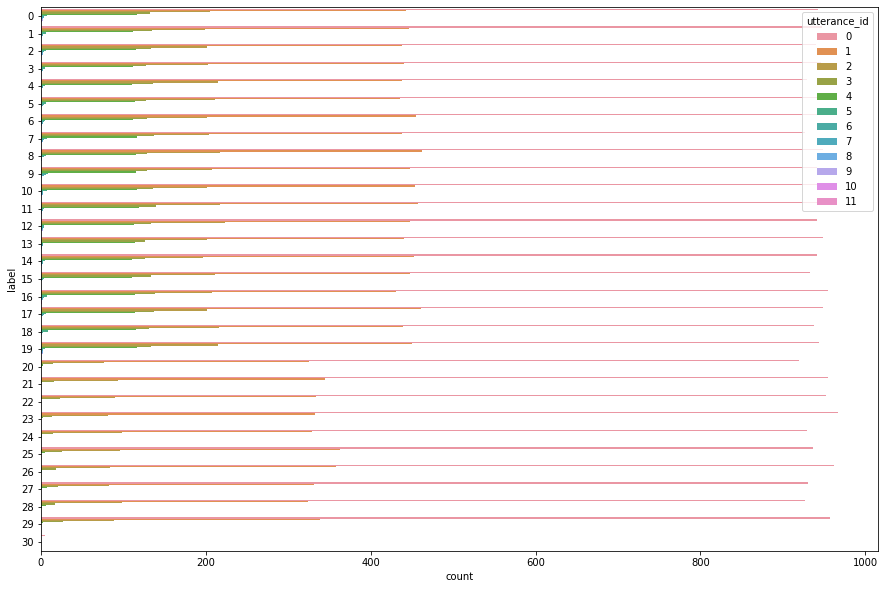

In [10]:
plt.figure(figsize=(15, 10))
sns.countplot(data=train_df, y='label', hue='utterance_id')

In [11]:
train_df['speaker_id'].unique().shape

(1504,)

# Build Dataset

In [12]:
pl.seed_everything(42)

Global seed set to 42


42

In [13]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/data2vec-audio-base")

Downloading:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [14]:
labels = dataset["train"].features["label"].names
label_map = dict([(index, label) for index, label in enumerate(labels)])

In [15]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True, padding=True
    )
    return inputs

In [16]:
encoded_dataset = dataset.map(preprocess_function, remove_columns="audio", batched=True)
encoded_dataset = encoded_dataset.rename_columns({'label': 'labels'})

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [17]:
encoded_dataset.set_format(type='torch', columns=['input_values', 'attention_mask', 'labels'])

In [18]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'labels', 'is_unknown', 'speaker_id', 'utterance_id', 'input_values', 'attention_mask'],
        num_rows: 51093
    })
    validation: Dataset({
        features: ['file', 'labels', 'is_unknown', 'speaker_id', 'utterance_id', 'input_values', 'attention_mask'],
        num_rows: 6799
    })
    test: Dataset({
        features: ['file', 'labels', 'is_unknown', 'speaker_id', 'utterance_id', 'input_values', 'attention_mask'],
        num_rows: 3081
    })
})

In [19]:
# Build pl lightning datamodule
class AudioLightningDataModule(pl.LightningDataModule):
  def __init__(self, encoded_dataset, batch_size=32):
    super(AudioLightningDataModule, self).__init__()
    self.encoded_dataset = encoded_dataset
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = self.encoded_dataset['train']
    self.validation_dataset = self.encoded_dataset['validation']
    self.test_dataset = self.encoded_dataset['test']

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, pin_memory=True,
        shuffle=True, batch_size=self.batch_size,
        num_workers=2
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.validation_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

  def test_dataloader(self) -> DataLoader:
    return DataLoader(
        self.test_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

In [20]:
datamodule = AudioLightningDataModule(encoded_dataset, batch_size=128)

# Build model

In [21]:
class AudioClassifer(pl.LightningModule):
  def __init__(self, num_class:int, num_training_steps):
    super(AudioClassifer, self).__init__()
    self.classifier = Data2VecAudioForSequenceClassification.from_pretrained(
        "facebook/data2vec-audio-base", num_labels=num_class
    )

    self.num_training_steps = num_training_steps

    self.train_acc = Accuracy()
    self.val_acc = Accuracy()

    self.test_acc = Accuracy()
    self.test_mcc = MatthewsCorrCoef(num_class)

  def forward(self, input_values, attention_mask, labels=None):
    return self.classifier(input_values=input_values, attention_mask=attention_mask, labels=labels)

  def training_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    loss = outputs.loss
    logits = outputs.logits

    self.train_acc(logits.argmax(dim=1), label)
    self.log('train_acc', self.train_acc, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    self.val_acc(logits.argmax(dim=1), label)
    self.log('val_acc', self.val_acc, prog_bar=True)

    return val_loss

  def test_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    logits = outputs.logits

    self.test_acc(logits.argmax(dim=1), label)
    self.test_mcc(logits.argmax(dim=1), label)

    self.log('test_acc', self.test_acc, prog_bar=True, logger=True)
    self.log('test_mcc', self.test_mcc, prog_bar=True, logger=True)

    return {
        'acc': self.test_acc,
        'mcc': self.test_mcc
    }

  def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
    return {
        'logits': self(**batch),
        'gt': batch['labels']
    }

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=self.trainer.estimated_stepping_batches,
    )

    return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler' : scheduler,
            'interval' : 'step'
        }
    }

In [22]:
batches_per_epoch = encoded_dataset['train'].num_rows // 128
total_train_steps = int(batches_per_epoch * 10)

model = AudioClassifer(num_class=len(label_map), num_training_steps=total_train_steps)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/355M [00:00<?, ?B/s]

Some weights of Data2VecAudioForSequenceClassification were not initialized from the model checkpoint at facebook/data2vec-audio-base and are newly initialized: ['classifier.bias', 'projector.weight', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Build trainer

In [23]:
# Define callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

In [24]:
# Setup trainer call
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu', devices=1,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, datamodule=datamodule)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type                                   | Params
----------------------------------------------------------------------
0 | classifier | Data2VecAudioForSequenceClassification | 93.4 M
1 | train_acc  | Accuracy                               | 0     
2 | val_acc    | Accuracy                               | 0     
3 | test_acc   | Accuracy                               | 0     
4 | test_mcc   | MatthewsCorrCoef                       | 0     
----------------------------------------------------------------------
93.4 M    Trainable params
0         Non-trainable params
93.4 M    Total params
373.476   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
trainer.test(model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

In [27]:
!nvidia-smi

Wed May 25 07:01:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    44W /  70W |   1446MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Evaluate model

In [39]:
from sklearn.metrics import classification_report, matthews_corrcoef

In [28]:
preds = trainer.predict(model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 400it [00:00, ?it/s]

In [32]:
y_true = []
y_pred = []

for result in preds:
  y_true.append(result['gt'].detach().cpu().numpy())
  y_pred.append(result['logits'].logits.detach().cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [35]:
print(
    classification_report(y_true, y_pred.argmax(axis=1), target_names=list(label_map.values()))
)

              precision    recall  f1-score   support

         yes       1.00      0.97      0.99       256
          no       1.00      0.94      0.97       252
          up       0.93      0.97      0.95       272
        down       1.00      0.97      0.98       253
        left       0.99      0.98      0.98       267
       right       1.00      0.97      0.98       259
          on       0.54      0.98      0.69       246
         off       1.00      0.97      0.98       262
        stop       1.00      0.99      0.99       249
          go       0.98      0.97      0.98       251
        zero       1.00      1.00      1.00        13
         one       0.83      0.94      0.88        16
         two       0.70      1.00      0.82        16
       three       0.88      0.93      0.90        15
        four       1.00      1.00      1.00         9
        five       1.00      1.00      1.00        23
         six       0.92      1.00      0.96        11
       seven       0.94    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print(matthews_corrcoef(y_true, y_pred.argmax(axis=1)))

0.8885452281711104


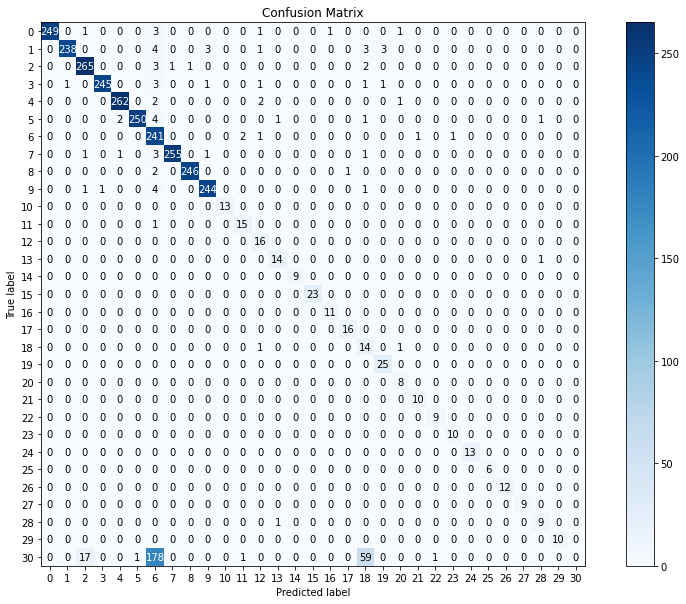

In [36]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred.argmax(axis=1), figsize=(15, 10))

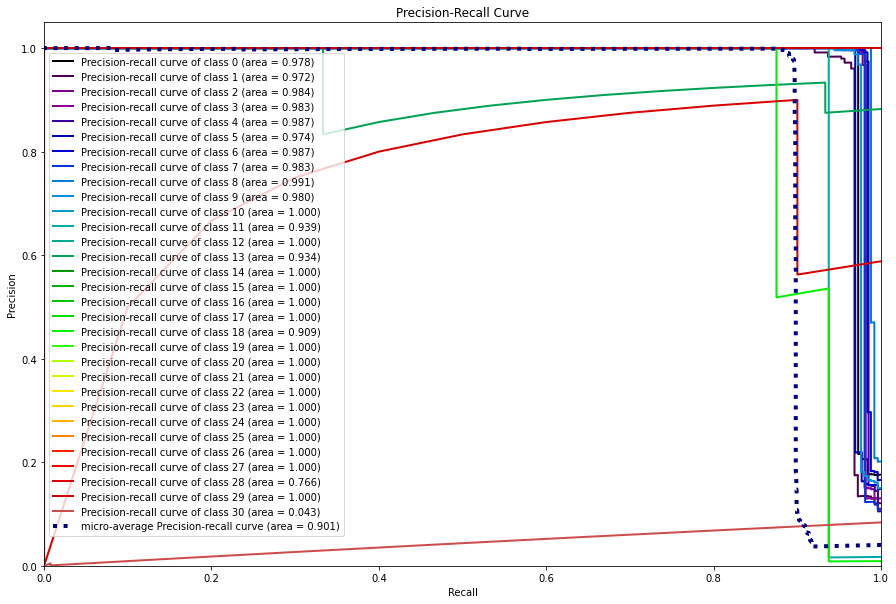

In [37]:
skplt.metrics.plot_precision_recall(y_true, y_pred, figsize=[15, 10])

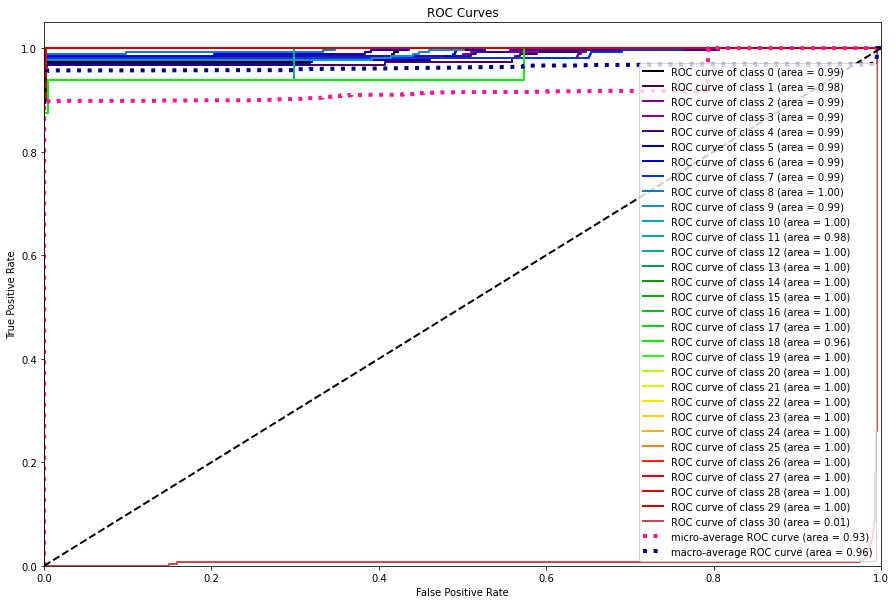

In [38]:
skplt.metrics.plot_roc(y_true, y_pred, figsize=[15, 10])

# Inference

In [58]:
random_var = np.random.choice(dataset['test'])

In [59]:
inputs = feature_extractor(
    random_var["audio"]['array'], sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True, padding=True
)

input_val = {
    'input_values': torch.tensor(inputs['input_values']),
    'attention_mask': torch.tensor(inputs['attention_mask'])
}

with torch.no_grad():
  outputs = model(**input_val)

In [63]:
wav.write('out.wav', random_var['audio']['sampling_rate'], random_var['audio']['array'])

print('Pred Label: {}, GT Label: {}\n'.format(outputs.logits.argmax(dim=1).item(), random_var['label']))
Audio('out.wav')

Pred Label: 7, GT Label: 7

